In [248]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline

# Optical simulation
In this notebook we present some insights about the optical aspect of lithography simulation


## Mask definition
We start by a simple example : a 1D mask composed of a single chromium dot centered on origin

Text(0, 0.5, 'Mask transmission')

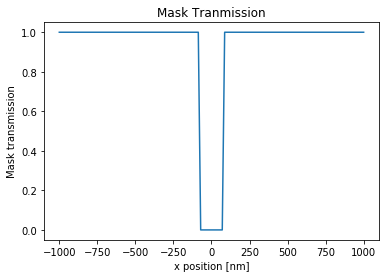

In [249]:
#Define the chromium dot size
dot_size=500.
#Define the x support
x_support=np.linspace(-1000.,1000.,128)
#Compute the pixel size
dx=2000./128
#Define the mask, 1 for glass, 0 for chromium
mask=[0 if np.abs(x)<150/2 else 1 for x in x_support ]
#Plot
plt.title('Mask Tranmission')
plt.plot(x_support, mask)
plt.xlabel('x position [nm]')
plt.ylabel('Mask transmission')

From there we compute **the Fourier Transform** of the mask.  
With numeric Fourier Transform one has to use the shift function to recenter the low frequency at the center for both spectrum and support.

Text(0, 0.5, 'Mask spectrum')

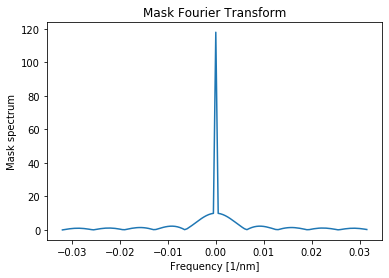

In [250]:
# Computation of the mask TF and its frequency support
mask_ft=np.fft.fftshift(np.fft.fft(mask))
freq_support=np.fft.fftshift(np.fft.fftfreq(128,d=dx))
# Plotting section
plt.title('Mask Fourier Transform')
plt.plot(freq_support,np.abs(mask_ft))
plt.xlabel('Frequency [1/nm]')
plt.ylabel('Mask spectrum')

## Source definition

The sources illuminates the mask with different angles.
In lithography the source is imaged by the optical system at the entrance pupil of the projection lens. 
Different shapes of source exist. The most simple one is the circular source.
If the source is circular its image trought the optical system is also circular, it is a circle of radius $\frac{\sigma NA}{\lambda}$

At this point we have all the source points that contribute to the formation of the aerial image.
Each source point in the source_points list corresponds to a frequency.
In fact, there is a correspondance between frequency and the angle of incidence of the ray on the mask.
$$f=\frac{\sin(\theta)}{\lambda}$$

In [251]:
def compute_aerial_image(sigma,NA,wavelength,frq):
    # Define the active source points of the circular source
    source_points=[f for f in frq if np.abs(f)<=sigma*NA/wavelength]
    # Initialisation of the aerial image as single precision
    aerial_image=np.zeros_like(mask_ft,dtype='float32')
    # Compute all source points contribution to the aerial image
    for freq_src in source_points:
        # Shift of the frequency support relative to the source point frequency
        freq_msk_shft = [(f - freq_src) for f in frq]
        # Shift of the projection lens pupil
        pupil_shifted = [1 if np.abs(f) <= NA/wavelength else 0 for f in freq_msk_shft]
        # The pupil applies a low pass filtre to the mask spectrum
        mask_lpf = np.multiply(mask_ft, pupil_shifted)
        # Add the contribution of the current src point to the overall aerial image
        aerial_image += np.abs(np.fft.ifft(mask_lpf)) ** 2
    # Normalisation with number of source points
    aerial_image /= len(source_points)
    # Plotting 
    plt.title(f'Aerial Image - {len(source_points)} source points')
    plt.plot(x_support,aerial_image)
    plt.xlabel('x position [nm]')
    plt.ylabel('Intensity [au]')

The Figure below let you change different parmeters to see the impact on the aerial image

In [252]:
interact(compute_aerial_image, sigma=(0.0,1.0,0.01),NA=(0.2,0.6,0.01),
         wavelength=[('436nm', 436), ('365nm', 365),('248nm', 248), ('193nm', 193)],frq=fixed(freq_support));

interactive(children=(FloatSlider(value=0.5, description='sigma', max=1.0, step=0.01), FloatSlider(value=0.4, …

<img src="img/hemisphere_target.png" width=500 />

![Kernel & front-end diagram](img/hemisphere_target.png) 

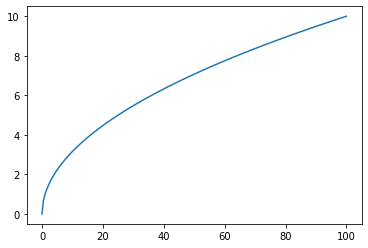

In [253]:
import numpy as np
import matplotlib.pyplot as plt

x=np.linspace(0,100,250)
function=np.sqrt(x)
plt.plot(x,function)
plt.show()

$$\tilde{H}(f,g)=\text{circ}\left(\frac{\sqrt{f^2+g^2}}{\frac{\text{NA}}{\lambda}}\right) $$

# Aerial image formulation

In the case of Fourier Optics and Scalar diffraction theory we can write the intensity as :

$$I(x,y)=\idotsint_{\infty}^{-\infty} \tilde{J}(f,g)\tilde{H}(f+f',g+g')\tilde{H}^*(f+f'',g+g'')\tilde{O}(f',g')\tilde{O}(f'',g'') \\ 
	e^{-2i\pi[(f'-f'')x+(g'-g'')y]}dfdgdf'dg'df''dg''$$

## Hopkins formulation
By changing the integration variables Hopkins proposed a different integration:

$$I(x,y)=\iiiint_{\infty}^{-\infty}TCC(f',g';f'',g'')\tilde{O}(f',g')\tilde{O}^{*}(f'',g'')e^{-2i\pi[(f'-f'')x+(g'-g'')y]}df'dg'df''dg''$$